# Smartphone and MCU-board data sync
This document provides an example of two independent system time sync:

1. A handheld system with rigidly attached IMU launched by an MCU board.
2. Motion Capture System (mocap) that captures movements of the handheld system by detecting light reflective markers rigidly attached to it.

The task is to find time offset between mocap and imu measurements.

Important clauses:
1. The case of these systems implies __angular velocity extraction from poses given by mocap__. It can be achieved by obtaining finite differences between orientations given by mocap. We do this procedure here.
2. Mocap system may miss poses for some timestamps, this drawback should be considered. The notebook solves this issue.
3. During data recording for this case, mocap system was triggered by MCU GPIO pin, this means there is __no clock drift__ between mocap and IMU data. Thus, only time offset to be estimated here. Clock drift handling to be done in another notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
import twistnsync as tns

def interp(t_old, f_old, t_new, kind='linear'):
    func = interp1d(t_old, f_old, kind=kind, axis=0, fill_value="extrapolate")
    f_new = func(t_new)
    return f_new

d = np.array([-1.0, 0.0, 1.0])

### Mocap data handler class

In [55]:
class MocapData:
    
    def __init__(self, path, fs=None):
        self.df = pd.read_csv(path, compression='zip')
        if fs is not None:
            self.df['timestamps'] = np.arange(self.df['timestamps'].shape[0])/fs
        self.indexes_whole = self.df.index
        self.indexes_notna = self.df[self.df.notna().all(axis=1)].index
    
    def get_data(self, notna_only=True):
        indexes = self.indexes_notna if notna_only else self.indexes_whole
        timestamps = self.df[['timestamps']].to_numpy().squeeze()[indexes]
        quats = self.df[['qx', 'qy', 'qz', 'qw']].to_numpy()[indexes]
        
        return timestamps, quats

### Read IMU timestamps and angular velocities

In [14]:
imu_data = pd.read_csv('imu.zip', compression='zip')
imu_timestamps = imu_data['t'].to_numpy().squeeze() * 1.0e-9
imu_ang_vel = imu_data[['ox', 'oy', 'oz']].to_numpy()

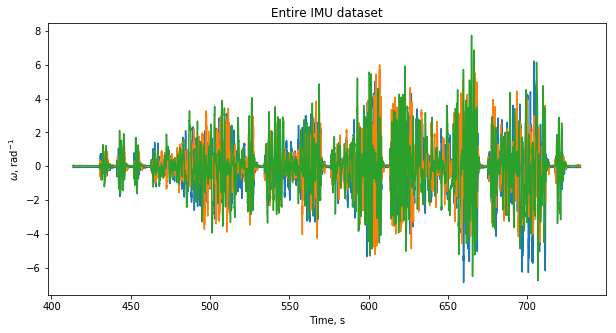

In [15]:
plt.figure(figsize=(10,5))
plt.title('Entire IMU dataset')
plt.xlabel('Time, s')
plt.ylabel(r'$\omega$, rad$^{-1}$')
plt.plot(imu_timestamps, imu_ang_vel);

### Take a look at non-zero IMU bias during motionless state of the platform.
The bias can be already removed if the IMU is calibrated beforehand

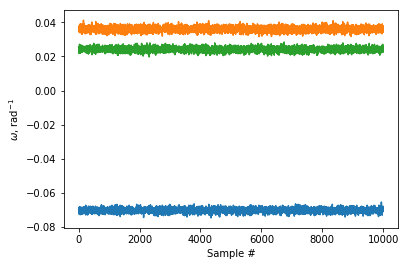

In [16]:
plt.plot(imu_ang_vel[:10000])
plt.xlabel('Sample #')
plt.ylabel(r'$\omega$, rad$^{-1}$');

### Subtracting of the bias from the IMU measurements

In [17]:
imu_ang_vel -= imu_ang_vel[:10000].mean(axis=0)

### Bias is removed:

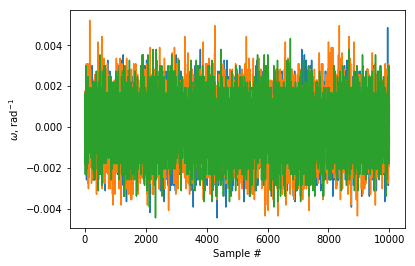

In [18]:
plt.plot(imu_ang_vel[:10000])
plt.xlabel('Sample #')
plt.ylabel(r'$\omega$, rad$^{-1}$');

### Read mocap data including timestamps and orientations

In [56]:
mocap_data_obj = MocapData('mocap.zip', fs=200.)
mocap_all_timestamps, mocap_all_quaternions = mocap_data_obj.get_data(notna_only=False)
mocap_notna_timestamps, mocap_notna_quaternions = mocap_data_obj.get_data(notna_only=True)
dt = np.diff(mocap_all_timestamps).mean()
print(f'Mocap data sampling period is {dt * 1000.} ms, rate is {1./dt} Hz')

Mocap data sampling period is 5.0 ms, rate is 200.0 Hz


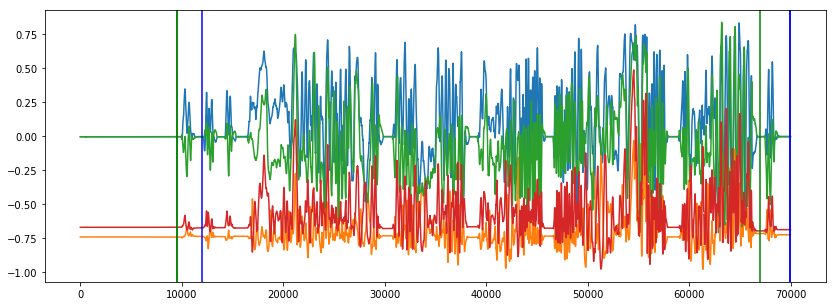

In [110]:
tns_mocap_timestamps = np.array([
    [9500, 12000], # the _beginning_ and the _end_ of a twistnsync trial (Figure 2.3 
                   # in https://mipt.ru/upload/medialibrary/f8b/dissertatsiya-fayzullin.pdf#figure.caption.16)
    [9500, 69990],
    [67000, 69990],
])

plt.figure(figsize=(14,5))
plt.plot(mocap_all_quaternions)

begins = tns_mocap_timestamps[:, 0]
ends = tns_mocap_timestamps[:, 1]

for begin, end in zip(begins, ends):
    plt.axvline(begin, c='g')
    plt.axvline(end, c='b')

In [102]:
def get_mocap_based_angular_velocity(time_notna, quats_notna, time_whole):
    orientation = Rot(quats_notna).as_matrix()
    orientation_interp = interp(time_notna, orientation, time_whole)
    dR = orientation_interp[:-2].transpose(0,2,1) @ orientation_interp[2:]
    dt = (time_whole[2:] - time_whole[:-2]).reshape(-1,1)
    ang_vel = Rot.from_matrix(dR).as_rotvec() / dt
    return ang_vel

mocap_ang_vel = get_mocap_based_angular_velocity(
    mocap_notna_timestamps, mocap_notna_quaternions, mocap_all_timestamps)

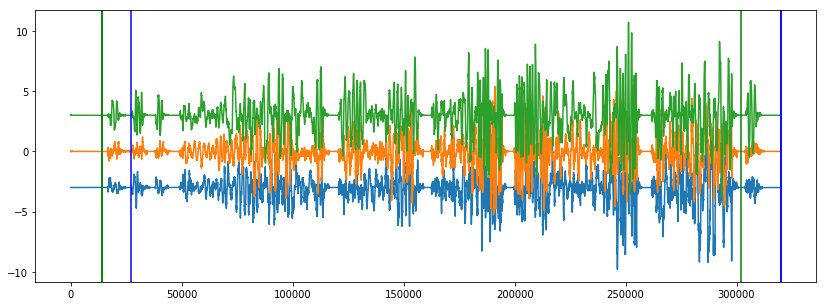

In [111]:
tns_imu_timestamps = np.array([
    [14000, 27000],
    [14000, 319990],
    [302000, 319990]
])

plt.figure(figsize=(14,5))
plt.plot(imu_ang_vel + d * 3)
for begin, end in zip(tns_imu_timestamps[:, 0], tns_imu_timestamps[:, 1]):
    plt.axvline(begin, c='g')
    plt.axvline(end, c='b')

-380564.6174699456 ms
-380564.7100401558 ms
-380564.69361630897 ms


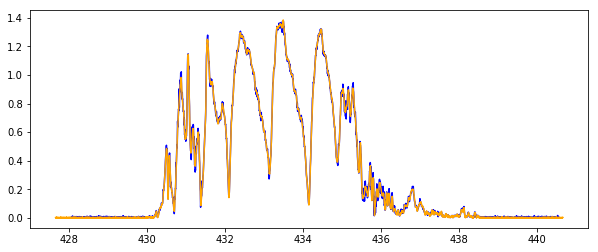

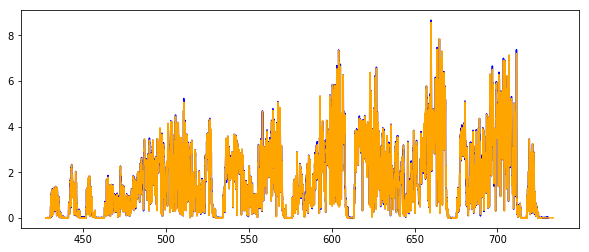

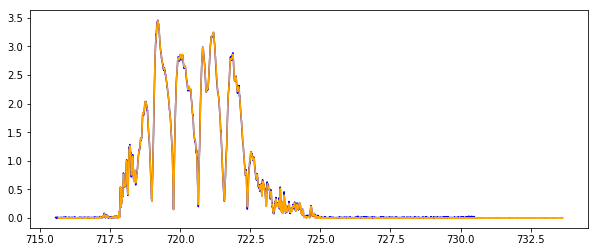

In [112]:
offsets = []
mcu_times = []
for i in range(tns_mocap_timestamps.shape[0]):    
    mocap_t = mocap_all_timestamps[tns_mocap_timestamps[i, 0]:tns_mocap_timestamps[i, 1]]
    mocap_av = mocap_ang_vel[tns_mocap_timestamps[i, 0]:tns_mocap_timestamps[i, 1]]
    imu_t = imu_timestamps[tns_imu_timestamps[i, 0]:tns_imu_timestamps[i, 1]]
    imu_av = imu_ang_vel[tns_imu_timestamps[i, 0]:tns_imu_timestamps[i, 1]]
    
    time_sync = tns.TimeSync(
        imu_av, mocap_av, imu_t, mocap_t, do_resample = True
    )
    time_sync.resample()
    time_sync.obtain_delay()
    # Check if IMU calibration and consequently TimeSync has succeeded
    if time_sync.calibration_is_succeeded == False or time_sync.calibration_is_succeeded is None:
        print('IMU data calibration failed. Exiting')

    comp_delay = time_sync.time_delay
    M = time_sync.M
    #print(M)
    # Compute resulting offset
    #mocap_mcu_clock_offset = np.mean(mocap_gyro_time - mcu_gyro_time) + comp_delay2
    mocap_mcu_clock_offset = (mocap_t[0] - imu_t[0] + comp_delay)
    offsets.append(mocap_mcu_clock_offset)
    print(mocap_mcu_clock_offset * 1000., 'ms')
    plt.figure(figsize=(10,4))
    plt.plot(mocap_t - mocap_mcu_clock_offset, np.linalg.norm(mocap_av, ord=2, axis=1), 'b')
    plt.plot(imu_t, np.linalg.norm(imu_av, ord=2, axis=1), 'orange')


# This is the final result, mocap timestamps in the IMU data time domain:

In [113]:
mocap_all_timestamps_aligned = mocap_all_timestamps - mocap_mcu_clock_offset
mocap_notna_timestamps_aligned = mocap_notna_timestamps - mocap_mcu_clock_offset

(-2.5, 2.5)

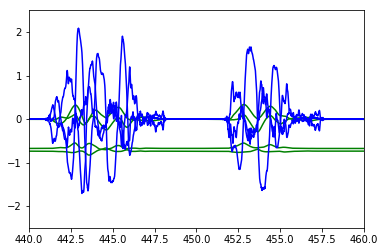

In [114]:
plt.plot(mocap_all_timestamps_aligned, mocap_all_quaternions, 'g')
plt.plot(imu_timestamps, imu_ang_vel, 'b')
plt.xlim(440, 460)
plt.ylim(-2.5,2.5)


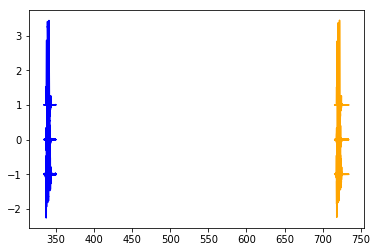

In [115]:
plt.plot(mocap_t, mocap_av + d, 'b')
plt.plot(imu_t, (time_sync.M @ imu_av.T).T + d, 'orange')


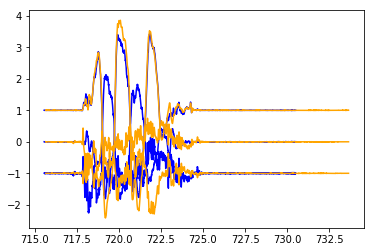

In [116]:
plt.plot(mocap_t - mocap_mcu_clock_offset, mocap_av + d, 'b')
plt.plot(imu_t, imu_av + d, 'orange')


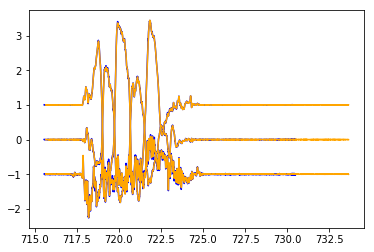

In [117]:
plt.plot(mocap_t - mocap_mcu_clock_offset, mocap_av + d, 'b')
plt.plot(imu_t, (time_sync.M @ imu_av.T).T + d, 'orange')
